In [1]:
#instal library
!pip -q install gradio
!pip -q install PySastrawi

     |████████████████████████████████| 2.9 MB 4.9 MB/s 
     |████████████████████████████████| 253 kB 68.6 MB/s 
     |████████████████████████████████| 2.0 MB 34.4 MB/s 
     |████████████████████████████████| 211 kB 54.5 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 50.5 MB/s 
     |████████████████████████████████| 144 kB 49.5 MB/s 
     |████████████████████████████████| 10.9 MB 29.6 MB/s 
     |████████████████████████████████| 58 kB 2.0 MB/s 
     |████████████████████████████████| 79 kB 2.3 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 61 kB 341 kB/s 
     |████████████████████████████████| 3.6 MB 14.9 MB/s 
     |████████████████████████

In [38]:
#import library
import string
import re
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import gradio as gr
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

nltk.download('punkt')
pd.set_option("display.max_colwidth", 1000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
#read dataset
df = pd.read_csv("review_hotel.csv")
df.head()

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pelayannya ramah dan banyak membantu. Lokasi cukup dekat ke beberapa obyek wisata. kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini.",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater untuk kopi/teh atau dispenser dan tidak tersedia kursi di depan kamar untuk merokok hingga harus duduk di lantai",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh jdi sarang nyamuk dikamar mandinya...pesan superior double yg dikasih twin...mungkin karena murah saya maklumin, tpi kedepan mohon untuk bisa jdi perbaikan untuk bisa lbh baik lg..",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk tidak diganti,",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


In [41]:
#check emoticon
df["review_text"].str.findall("(:\S+)").explode().value_counts()

:(                         145
:)                          42
:00                         16
:((                          8
:'(                          4
:49                          3
:))                          2
:p                           2
:15                          2
:30                          2
:00,                         2
:v                           2
:00.                         2
:(((                         2
:"                           1
:wastafel                    1
:((..                        1
:di                          1
:09)                         1
:30-20.00                    1
:-)                          1
:kamar                       1
:),                          1
:00an.                       1
://youtu.be/6t2Hqf0-HuU      1
:')                          1
:(((((((                     1
::                           1
:P                           1
:;                           1
:-                           1
:57                          1
:55     

In [42]:
#check exclamation mark
df["review_text"].str.findall("\w+!").explode().value_counts()

banget!          9
kecewa!          9
mengecewakan!    8
bad!             7
recommended!     7
                ..
gmn!             1
affordable!      1
EVER!            1
parrah!          1
Menyebalkan!     1
Name: review_text, Length: 286, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


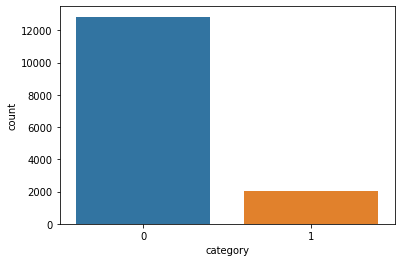

In [43]:
#visualization
sn.countplot(df['category'])

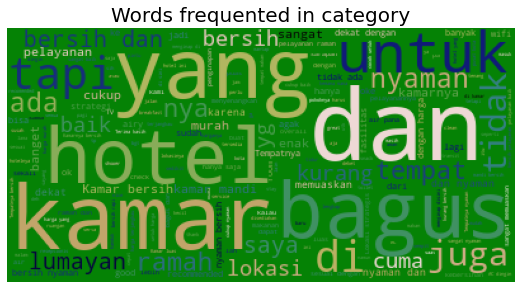

In [44]:
#visualising the subset datasets using wordcloud  
def wordcloud(df, label):
    subset=df[df[label]==1]
    text=subset.review_text.values
    wc= WordCloud(background_color="green",max_words=2000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98) 

wordcloud(df,'category')

In [45]:
#edit punctuations
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

def separate_punct(text):
    return re.sub(r"(\w+)(!)", r"\1 \2", text)

In [48]:
#text preprocessing
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    text = separate_punct(text)
    # text = stemmer.stem(text)
    return text

In [49]:
#text cleaning
df["cleaned_text"] = df["review_text"].apply(preprocess_text)
df.head()

,review_id,review_text,category,cleaned_text
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pelayannya ramah dan banyak membantu. Lokasi cukup dekat ke beberapa obyek wisata. kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini.",1,penginapannya rapi bersih suasana tenang pelayannya ramah dan banyak membantu lokasi cukup dekat ke beberapa obyek wisata kalau saya ke bandung lagi mungkin saya akan menginap lagi di sini
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater untuk kopi/teh atau dispenser dan tidak tersedia kursi di depan kamar untuk merokok hingga harus duduk di lantai",0,wifi tidak sampai kamar tidak tersedia heater untuk kopi teh atau dispenser dan tidak tersedia kursi di depan kamar untuk merokok hingga harus duduk di lantai
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh jdi sarang nyamuk dikamar mandinya...pesan superior double yg dikasih twin...mungkin karena murah saya maklumin, tpi kedepan mohon untuk bisa jdi perbaikan untuk bisa lbh baik lg..",0,lantai kamar mandi kotor bau dan seperti sdh jdi sarang nyamuk dikamar mandinya pesan superior double yg dikasih twin mungkin karena murah saya maklumin tpi kedepan mohon untuk bisa jdi perbaikan untuk bisa lbh baik lg
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk tidak diganti,",0,wc jorok kasur tidak dibersihkan handuk tidak diganti
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,bocor lagi


In [50]:
#feature extractions
cleaned_text = df["cleaned_text"]

In [51]:
#count vector
count_vect = CountVectorizer(max_features=10_000)
count_repr = count_vect.fit_transform(cleaned_text)
count_repr

<14856x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 213952 stored elements in Compressed Sparse Row format>

In [52]:
#Tf-Idf
tfidf_vect = TfidfVectorizer(max_features=10_000)
tfidf_repr = tfidf_vect.fit_transform(cleaned_text)
tfidf_repr

<14856x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 213952 stored elements in Compressed Sparse Row format>

In [53]:
#model building
logres = LogisticRegression()
multi_nb = MultinomialNB()

In [54]:
#labeling
target = df["category"]
features = df["cleaned_text"]

In [56]:
#split data
train_X, test_X, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=42)

In [57]:
#pipeline logistic
logres_pipe = Pipeline([("feature_extractions", tfidf_vect),
                        ("classifier", logres)])

#pipeline naive bayes
multinb_pipe = Pipeline([("feature_extractions", count_vect),
                         ("classifier", multi_nb)])

In [62]:
#train model (logestic regression)
logres_pipe.fit(train_X, train_y)
logres_pipe.score(test_X, test_y)

0.9471736204576043

In [60]:
#train model (naive bayes)
multinb_pipe.fit(train_X, train_y)
multinb_pipe.score(test_X, test_y)

0.9434724091520862

In [63]:
#model evaluation (logistic regression)
logres_report = classification_report(y_true=test_y, y_pred=logres_pipe.predict(test_X))
print(logres_report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2589
           1       0.93      0.64      0.76       383

    accuracy                           0.95      2972
   macro avg       0.94      0.82      0.86      2972
weighted avg       0.95      0.95      0.94      2972



In [64]:
#model evaluation (multinomial naive bayes)
multinb_report = classification_report(y_true=test_y, y_pred=multinb_pipe.predict(test_X))
print(multinb_report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2589
           1       0.84      0.69      0.76       383

    accuracy                           0.94      2972
   macro avg       0.90      0.84      0.86      2972
weighted avg       0.94      0.94      0.94      2972



In [65]:
#provide information on labels 0 and 1
category_map = {0: "Negatif", 1: "Positif"}

#main function to be executed
def predict_category(review):

    prediction = int( logres_pipe.predict([review]) )
    category = category_map.get(prediction)

    return category

predict_category("kamarnya sangat luas")

'Positif'